In [2]:
## Importing necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
import seaborn as sns

In [3]:
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


In [6]:
data = pd.read_csv('Data')
data.head()

,MDR_REPORT_KEY,DATE_RECEIVED,GENERIC_NAME,MANUFACTURER_D_NAME,MANUFACTURER_D_CITY,MANUFACTURER_D_STATE_CODE,MANUFACTURER_D_POSTAL_CODE,DEVICE_OPERATOR,EXPIRATION_DATE_OF_DEVICE,MODEL_NUMBER,...,COMBINATION_PRODUCT_FLAG,UDI-DI,MDR_TEXT_KEY,TEXT_TYPE_CODE,PATIENT_SEQUENCE_NUMBER,FOI_TEXT,tokens,updated_text,ner_results,QUARTER_DATE_RECEIVED
0,8207400,2019-01-01,IMPLANTABLE CARDIOVERTER DEFIBRILLATOR,"ST. JUDE MEDICAL, INC.",SUNNYVALE,CA,94085,HEALTH PROFESSIONAL,2013-09-30,CD3249-40Q,...,NO,5.414735e+12,131761474,N,1,THE RESULTS OF THE INVESTIGATION ARE INCONCLUS...,"['results', 'investigation', 'inconclusive', '...",{},"[('ANALYSIS', 'PRODUCT'), ('CONCLUSIVELY', 'OR...",2019Q1
1,8207416,2019-01-01,IMPLANTABLE CARDIOVERTER DEFIBRILLATOR,"ST. JUDE MEDICAL, INC.",SYLMAR,CA,91342,HEALTH PROFESSIONAL,2016-06-30,CD3365-40Q,...,NO,5.414735e+12,131761530,N,1,THE RESULTS OF THE INVESTIGATION ARE INCONCLUS...,"['results', 'investigation', 'inconclusive', '...",{},"[('ANALYSIS', 'PRODUCT'), ('CONCLUSIVELY', 'OR...",2019Q1
2,8207424,2019-01-01,IMPLANTABLE CARDIOVERTER DEFIBRILLATOR,"ST. JUDE MEDICAL, INC.",SYLMAR,CA,91342,HEALTH PROFESSIONAL,2015-03-31,CD3265-40Q,...,NO,5.414735e+12,131761374,N,1,THE DEVICE IS INCLUDED IN THE PREMATURE BATTER...,"['included', 'premature', 'battery', 'depletio...","{'Battery problem': ['depletion'], 'Device iss...","[('2016', 'DATE'), ('ANALYSIS', 'PRODUCT'), ('...",2019Q1
3,8208549,2019-01-02,IMPLANTABLE CARDIOVERTER DEFIBRILLATOR,"ST. JUDE MEDICAL, INC.",SYLMAR,CA,91342,HEALTH PROFESSIONAL,2012-10-31,CD2231-40Q,...,NO,5.414735e+12,131793503,N,1,THE DEVICE IS INCLUDED IN THE PREMATURE BATTER...,"['included', 'premature', 'battery', 'depletio...","{'Battery problem': ['depletion'], 'Device iss...","[('11 OCTOBER 2016', 'DATE')]",2019Q1
4,8209283,2019-01-02,IMPLANTABLE PACEMAKER PULSE GENERATOR,"ST. JUDE MEDICAL, INC.",SYLMAR,CA,91342,HEALTH PROFESSIONAL,2012-02-29,5826,...,NO,5.414735e+12,131814304,D,1,THE PATIENT PRESENTED IN THE EMERGENCY ROOM DU...,"['emergency', 'room', 'due', 'ventricular', 'f...","{'Hospitalization': ['emergency', 'admitted']}",[('THE PHYSICIAN ATTEMPTED TO INTERROGATED THE...,2019Q1


In [7]:
data['adverse_events'] = data['FOI_TEXT'].str.lower()
data['adverse_events'].dropna(inplace=True)
stop_words = set(stopwords.words('english'))

In [9]:
## Creating custom stopwords to eliminate tfrom data
custom_stop_words = set(['patient','device','reported','implantable','stable','presented','pacemaker',
                        'defibrillator','cardioverter','condition','performed'])
stop_words = stop_words.union(custom_stop_words)

In [10]:
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    # Tokenize sentences
    sentences = sent_tokenize(text)
    processed_text = []

    for sentence in sentences:
        # Tokenize words
        words = word_tokenize(sentence)
        # Remove special characters, symbols, URLs, punctuations, numbers
        words = [re.sub(r'[^\w\s]', '', word) for word in words if word.isalpha()]
        # Lemmatize words
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        # Filter short and long words
        words = [word for word in words if 1 < len(word) < 20]
        processed_text.extend(words)

    return processed_text

In [11]:
## Applying the function to the column
data['adverse_events'] = data['adverse_events'].apply(preprocess_text)

In [13]:
## key-word pair dcitionary
adverse_events_keywords = {
   "Discomfort": ["discomfort", "dehiscense", "dyspnea", "fever","vomiting","irritation"],
    "Pain": ["debridement", "wound", "dehiscence", "hematoma", "suffering", "ache","pain"],
    "Hospitalization": ["debridement", "prosthetic", "hospital", "admitted", "hospitalized",
                        "predischarge", "surgeries", "therapy", "emergency"],
    "Sensing": ["noise", "communicating", "disconnected", "oversensing", "threshold", "noisy",
                "undersensed",'loss of capture','capture'],
    "Lead Dislodgement": ["lead dislogement", "electrode", "li"],
    "Device issues": ["charge", "depletion", "impedance", "discharged", "impedances", "drain",
                     "battery performance", "depletion", "short", "circuit", "low amplitude",
                      "electrical discharge", "impedance", "threshold", "drainage", "voltage"],
    "Heart complications": ["endocarditis", "cardiopulmonary", "ischemia", "stroke", "tamponade",
                            "stenosis", "pulse", "bradycardia", "sinus", "resuscitation" ],
    "Organ Impairment": ["debridement", "impairment", "diaphragmatic", "sepsis"],
    "Infection": ["infection", "redness", "bacteremia", "bacterial", "infectious"],
    "Mortality": ["death", "dead"],
    "Bleeding": ["blood", "blood loss", "cut","hematoma"],
    "Surgical Complications": ["dislodgement", "setscrew", "dehiscence"],
    "Lead Fracture": ["lead fracture", "chest discomfort", "syncope",'break'],
    "Dizziness": ["dizziness", "exhausted", "exhaustion", "sluggishness", "syncope"],
    "Mental stress": ["exhaustion", "shock", "anxiety", "fatigue"],
    "Pocket Erosion": ["pocket erosion",'pocket','erosion'],
    "Swelling": ["swelling", "swollen", "redness", "red"],
}

In [15]:
## Keyword Mating
def keyword_matching(text):
    matched_events = {}
    for event, keywords in adverse_events_keywords.items():
        matches = [word for word in text if word in keywords]
        if matches:
            matched_events[event] = matches
    return matched_events

data['adverse_events'] = data['adverse_events'].apply(keyword_matching)

In [16]:
def extract_keys(d):
    return list(d.keys())

In [17]:
data['occured_events']= data['adverse_events'].apply(extract_keys)

In [18]:
data['occured_events']

,occured_events
0,[]
1,[]
2,[Device issues]
3,[Device issues]
4,[Hospitalization]
...,...
10384,"[Device issues, Mental stress]"
10385,"[Sensing, Pocket Erosion]"
10386,[Device issues]
10387,[Device issues]


In [19]:
def count_events(data):
    return len(data)

In [20]:
data['no of events'] = data['occured_events'].apply(count_events)

In [21]:
event_counts = defaultdict(int)
for i in data['adverse_events']:
    for event in i.keys():
        event_counts[event] += 1

In [22]:
event_counts

defaultdict(int,
            {'Device issues': 2269,
             'Hospitalization': 1194,
             'Discomfort': 150,
             'Lead Dislodgement': 116,
             'Sensing': 2757,
             'Infection': 815,
             'Pocket Erosion': 561,
             'Mortality': 147,
             'Mental stress': 885,
             'Pain': 132,
             'Organ Impairment': 32,
             'Bleeding': 303,
             'Heart complications': 289,
             'Surgical Complications': 100,
             'Swelling': 107,
             'Dizziness': 222,
             'Lead Fracture': 93})

In [23]:
total_reports = len(data)
event_freq = { event: round(count/total_reports * 100,2) for event,count in event_counts.items()}

In [25]:
##Events and their frequency of occurance
event_freq

{'Device issues': 21.84,
 'Hospitalization': 11.49,
 'Discomfort': 1.44,
 'Lead Dislodgement': 1.12,
 'Sensing': 26.54,
 'Infection': 7.84,
 'Pocket Erosion': 5.4,
 'Mortality': 1.41,
 'Mental stress': 8.52,
 'Pain': 1.27,
 'Organ Impairment': 0.31,
 'Bleeding': 2.92,
 'Heart complications': 2.78,
 'Surgical Complications': 0.96,
 'Swelling': 1.03,
 'Dizziness': 2.14,
 'Lead Fracture': 0.9}

In [26]:
freq = {'Events':event_freq.keys(),
       'Frequency':event_freq.values()}
event_freq_df = pd.DataFrame(freq,index=None)
event_freq_df

,Events,Frequency
0,Device issues,21.84
1,Hospitalization,11.49
2,Discomfort,1.44
3,Lead Dislodgement,1.12
4,Sensing,26.54
5,Infection,7.84
6,Pocket Erosion,5.40
7,Mortality,1.41
8,Mental stress,8.52
9,Pain,1.27


In [27]:
## Sorting the frequncy in a descending order
summary_df_sorted = event_freq_df.sort_values(by='Frequency', ascending=False)
summary_df_sorted

,Events,Frequency
4,Sensing,26.54
0,Device issues,21.84
1,Hospitalization,11.49
8,Mental stress,8.52
5,Infection,7.84
6,Pocket Erosion,5.40
11,Bleeding,2.92
12,Heart complications,2.78
15,Dizziness,2.14
2,Discomfort,1.44


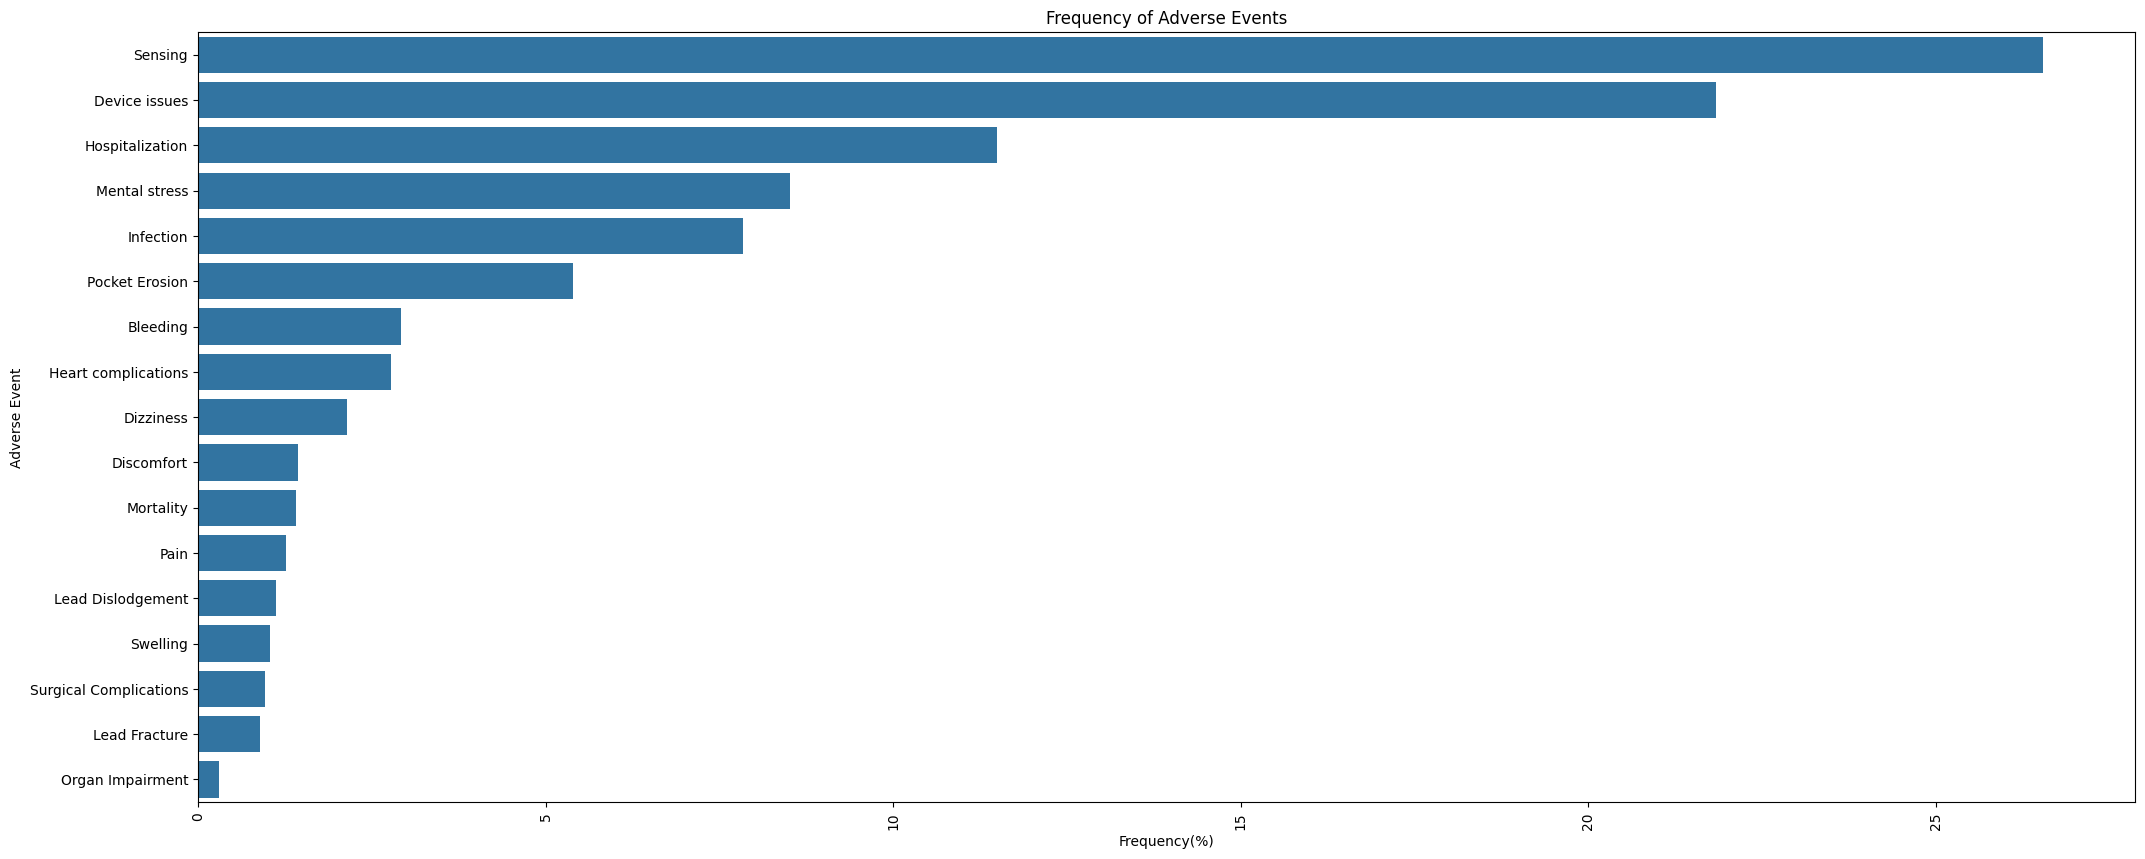

In [28]:
## Barplot for Frequncy and adverse events
plt.figure(figsize=(25, 10))
sns.barplot(data=summary_df_sorted, x='Frequency', y='Events',orient='h')
plt.xticks(rotation=90)
plt.xlabel('Frequency(%)')
plt.ylabel('Adverse Event')
plt.title('Frequency of Adverse Events')
plt.show()

In [32]:
## Defining the weights for severity
severity_weights = {
    "Discomfort": 1,
    "Pain": 3,
    "Hospitalization": 4,
    'Sensing': 3,
    "Lead Dislodgement": 4,
    "Device issues": 4,
    "Heart complications": 5,
    "Organ Impairment": 5,
    "Infection": 3,
    "Mortality": 5,
    "Bleeding": 3,
    "Surgical Complications": 5,
    "Lead Fracture": 5,
    "Dizziness": 2,
    "Mental stress": 2,
    "Pocket Erosion": 3,
    "Swelling": 2,
}

In [33]:
## Calculating the score for each report
def calculate_score(events):
    if not events:
        return 0
    total_score = 0
    for i in events:
        freq=event_freq.get(i,0)
        weight = severity_weights.get(i,0)
        total_score += freq*weight
    return round(total_score/total_reports,3)
data['OSI_score'] = data['occured_events'].apply(calculate_score)
data['OSI_score']

,OSI_score
0,0.000
1,0.000
2,0.008
3,0.008
4,0.004
...,...
10384,0.010
10385,0.009
10386,0.008
10387,0.008


In [34]:
score_value_count = data['OSI_score'].value_counts()
score_value_count=score_value_count.sort_index(ascending=False)
score_value_count

,count
OSI_score,
0.024,1
0.023,7
0.022,23
0.021,14
0.020,35
0.019,1
0.018,73
0.017,28
0.016,244


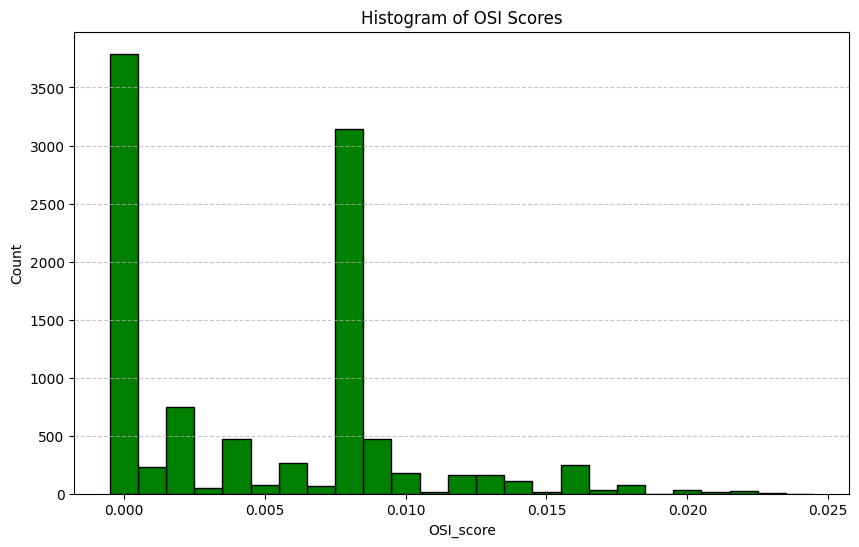

In [35]:
## Histogram for distribution of OSI scores in the data
score_data = {
    'OSI_score': score_value_count.index,
    'count': score_value_count.values
}

df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
plt.bar(score_data['OSI_score'], score_data['count'], width=0.001, color='green', edgecolor='black')
plt.xlabel('OSI_score')
plt.ylabel('Count')
plt.title('Histogram of OSI Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [38]:
## Function for label allocation
def label_allocation(score):
    if 0<=score<=0.006:
        return "Mild"
    elif 0.006<score<=0.012:
        return "Moderate"
    elif 0.012<score<=0.016:
        return "Severe"
    elif score>0.016:
        return "Fatal"

data['labels'] = data['OSI_score'].apply(label_allocation)
data['labels']

,labels
0,Mild
1,Mild
2,Moderate
3,Moderate
4,Mild
...,...
10384,Moderate
10385,Moderate
10386,Moderate
10387,Moderate


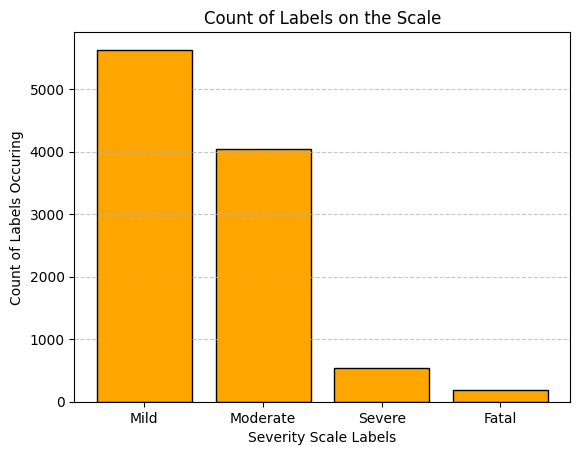

In [40]:
## Histogram for labels
y = data['labels'].value_counts().values
x = data['labels'].value_counts().index
plt.bar(x,y,color='orange',edgecolor='black')
plt.title("Count of Labels on the Scale")
plt.xlabel('Severity Scale Labels')
plt.ylabel('Count of Labels Occuring')
plt.grid(axis='y',linestyle='--',alpha=0.7)

In [41]:
updated_data = data[['GENERIC_NAME','MANUFACTURER_D_NAME','MANUFACTURER_D_STATE_CODE',
          'DEVICE_OPERATOR','MODEL_NUMBER','DEVICE_EVALUATED_BY_MANUFACTUR','DEVICE_REPORT_PRODUCT_CODE',
        'no of events','labels'
         ]]

In [42]:
updated_data.head()

,GENERIC_NAME,MANUFACTURER_D_NAME,MANUFACTURER_D_STATE_CODE,DEVICE_OPERATOR,MODEL_NUMBER,DEVICE_EVALUATED_BY_MANUFACTUR,DEVICE_REPORT_PRODUCT_CODE,no of events,labels
0,IMPLANTABLE CARDIOVERTER DEFIBRILLATOR,"ST. JUDE MEDICAL, INC.",CA,HEALTH PROFESSIONAL,CD3249-40Q,NOT RETURNED,NIK,0,Mild
1,IMPLANTABLE CARDIOVERTER DEFIBRILLATOR,"ST. JUDE MEDICAL, INC.",CA,HEALTH PROFESSIONAL,CD3365-40Q,YES,NIK,0,Mild
2,IMPLANTABLE CARDIOVERTER DEFIBRILLATOR,"ST. JUDE MEDICAL, INC.",CA,HEALTH PROFESSIONAL,CD3265-40Q,YES,NIK,1,Moderate
3,IMPLANTABLE CARDIOVERTER DEFIBRILLATOR,"ST. JUDE MEDICAL, INC.",CA,HEALTH PROFESSIONAL,CD2231-40Q,YES,NVZ,1,Moderate
4,IMPLANTABLE PACEMAKER PULSE GENERATOR,"ST. JUDE MEDICAL, INC.",CA,HEALTH PROFESSIONAL,5826,YES,LWP,1,Mild


In [44]:
## Label Encoding
le = LabelEncoder()
updated_data['GENERIC_NAME'] = le.fit_transform(data['GENERIC_NAME'])
updated_data['MANUFACTURER_D_NAME'] = le.fit_transform(data['MANUFACTURER_D_NAME'])
updated_data['MANUFACTURER_D_STATE_CODE'] = le.fit_transform(data['MANUFACTURER_D_STATE_CODE'])
updated_data['DEVICE_OPERATOR'] = le.fit_transform(data['DEVICE_OPERATOR'])
updated_data['MODEL_NUMBER'] = le.fit_transform(data['MODEL_NUMBER'])
updated_data['DEVICE_EVALUATED_BY_MANUFACTUR'] = le.fit_transform(data['DEVICE_EVALUATED_BY_MANUFACTUR'])
updated_data['DEVICE_REPORT_PRODUCT_CODE'] = le.fit_transform(data['DEVICE_REPORT_PRODUCT_CODE'])

<ipython-input-44-6741b0b89d46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_data['GENERIC_NAME'] = le.fit_transform(data['GENERIC_NAME'])
<ipython-input-44-6741b0b89d46>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_data['MANUFACTURER_D_NAME'] = le.fit_transform(data['MANUFACTURER_D_NAME'])
<ipython-input-44-6741b0b89d46>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [45]:
X = updated_data[['GENERIC_NAME', 'MANUFACTURER_D_NAME', 'MANUFACTURER_D_STATE_CODE',
       'DEVICE_OPERATOR', 'MODEL_NUMBER', 'DEVICE_EVALUATED_BY_MANUFACTUR',
       'DEVICE_REPORT_PRODUCT_CODE', 'no of events']]
y = updated_data['labels']

In [46]:
## Splitting the data into train,test and split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [47]:
## Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
## Defining the models
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest Classifier":RandomForestClassifier()
}


In [50]:
# Train and evaluate each model
l = []
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    l.append({model_name :accuracy_score(y_test,y_pred)})

    # Evaluate the model
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
print(l)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

       Fatal       0.40      0.23      0.29        35
        Mild       0.77      0.79      0.78      1126
    Moderate       0.60      0.66      0.63       806
      Severe       0.35      0.08      0.13       111

    accuracy                           0.69      2078
   macro avg       0.53      0.44      0.46      2078
weighted avg       0.68      0.69      0.68      2078


SVM Classification Report:
              precision    recall  f1-score   support

       Fatal       0.22      0.11      0.15        35
        Mild       0.87      0.73      0.80      1126
    Moderate       0.67      0.89      0.77       806
      Severe       0.47      0.25      0.33       111

    accuracy                           0.76      2078
   macro avg       0.56      0.50      0.51      2078
weighted avg       0.76      0.76      0.75      2078


Random Forest Classifier Classification Report:
         

In [51]:
RFC_model = model

In [52]:
RFC_model

RandomForestClassifier()

In [53]:
# Evaluation Metrics for RandomForest Classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.7743022136669875
Precision (macro): 0.5799052049668071
Recall (macro): 0.5663625499398719
F1 Score (macro): 0.5715529676589345


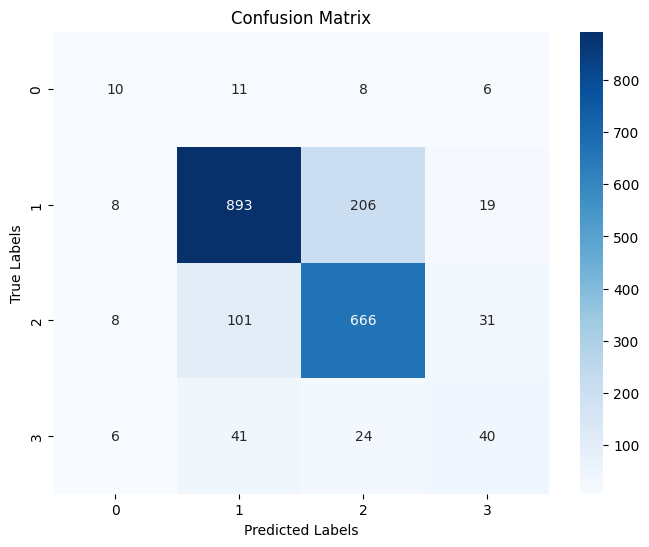

In [54]:
## Confusion Matrix
conf_matrix = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [55]:
# ROC-AUC Score (for binary classification)
if len(model.classes_) == 2:  # Check if binary classification
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

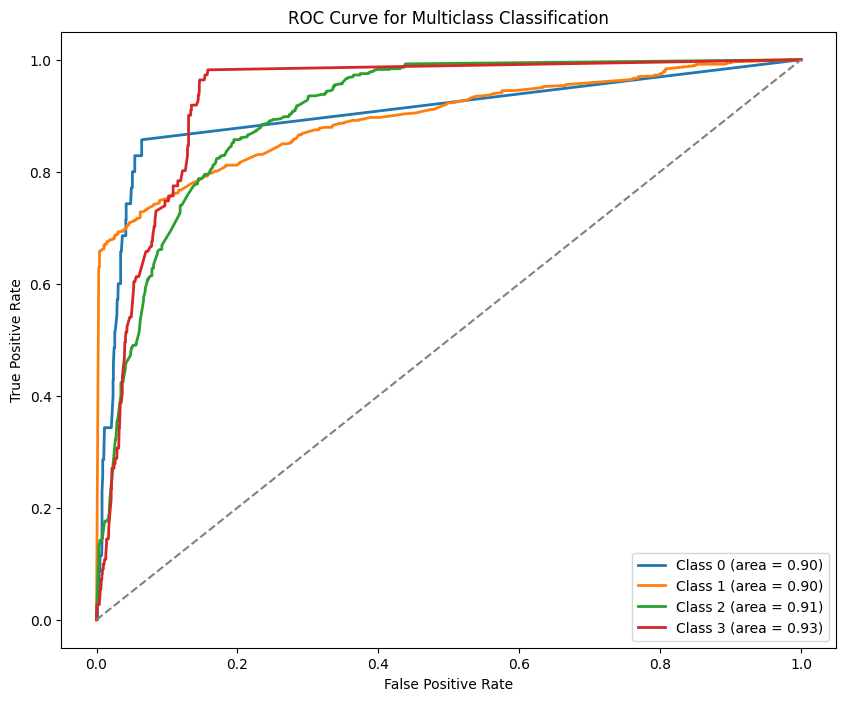

Macro-average ROC-AUC: 0.91


In [56]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np

# Binarize the labels for one-vs-rest ROC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_binarized.shape[1]

# Get probability estimates from the model for each class
y_pred_proba = model.predict_proba(X_test)

# Plotting the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

# Plotting the diagonal line for random chance
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

# Calculate the macro-average ROC-AUC
macro_roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average="macro")
print(f"Macro-average ROC-AUC: {macro_roc_auc:.2f}")

In [57]:
## Hyper-parameter Tunning in RandomForestClassifier

In [58]:
from sklearn.model_selection import GridSearchCV

In [59]:
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],        # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],        # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples required to be at a leaf node
    'bootstrap': [True, False]              # Whether bootstrap samples are used
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [60]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation Score: 0.7753561807094742


In [61]:
best_rf = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Fatal       0.17      0.03      0.05        35
        Mild       0.85      0.79      0.82      1126
    Moderate       0.71      0.87      0.78       806
      Severe       0.48      0.21      0.29       111

    accuracy                           0.77      2078
   macro avg       0.55      0.47      0.48      2078
weighted avg       0.77      0.77      0.76      2078



In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution for RandomizedSearch
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1,
                                   verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

# Best parameters and model performance
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Use the best estimator
best_rf = random_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 134}
Best Cross-Validation Score: 0.7751155791839519
              precision    recall  f1-score   support

       Fatal       0.17      0.03      0.05        35
        Mild       0.85      0.78      0.82      1126
    Moderate       0.70      0.86      0.77       806
      Severe       0.44      0.19      0.26       111

    accuracy                           0.77      2078
   macro avg       0.54      0.47      0.48      2078
weighted avg       0.76      0.77      0.76      2078



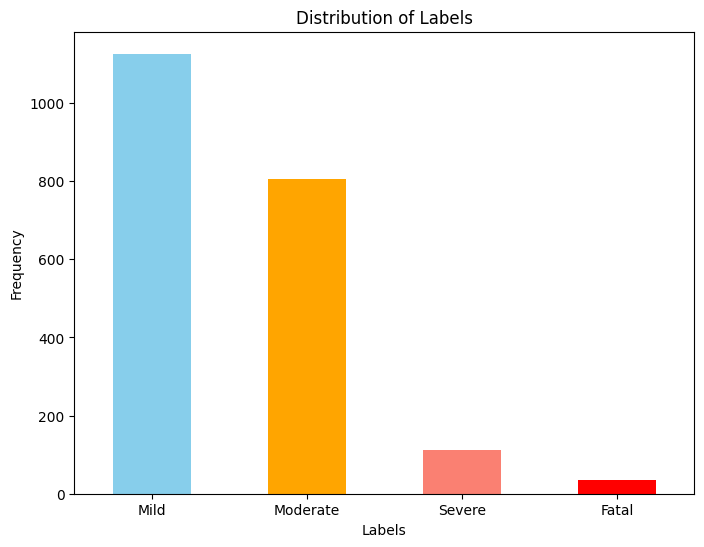

In [64]:
## Visualization for labels
plt.figure(figsize=(8, 6))
y_test.value_counts().plot(kind='bar', color=['skyblue', 'orange', 'salmon','red'])
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

In [65]:
y_pred = pd.Series(y_pred)
y_pred = pd.Series(y_pred)

In [66]:
y_pred

,0
0,Moderate
1,Mild
2,Moderate
3,Moderate
4,Mild
...,...
2073,Mild
2074,Mild
2075,Moderate
2076,Mild


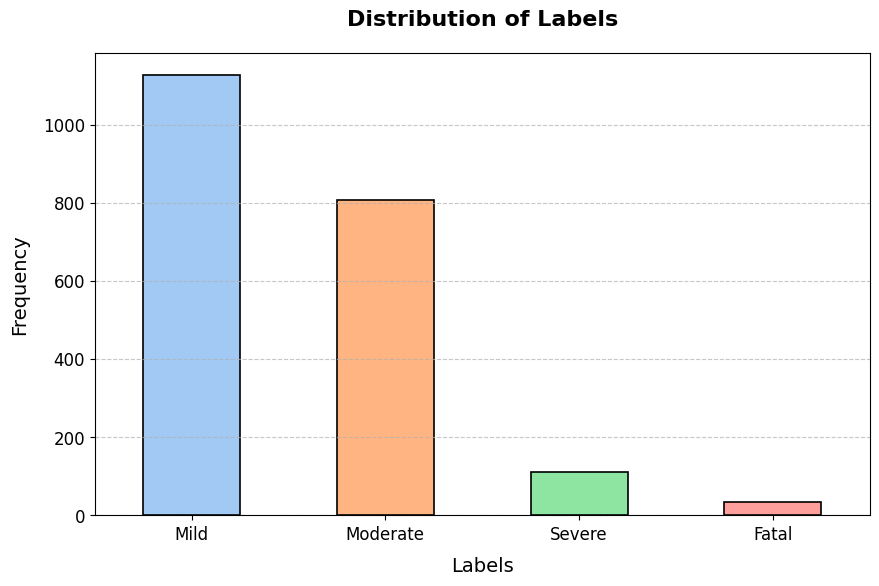

In [67]:
# Create the figure and axes
plt.figure(figsize=(10, 6))

# Enhanced color palette
colors = sns.color_palette("pastel", 4)

# Plot the data with better colors and visual adjustments
y_test.value_counts().plot(
    kind='bar',
    color=colors,
    edgecolor='black',
    linewidth=1.2
)

# Add title and labels with improved formatting
plt.title("Distribution of Labels", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Labels", fontsize=14, labelpad=10)
plt.ylabel("Frequency", fontsize=14, labelpad=10)

# Customize ticks
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Add a grid for y-axis only
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()